In [37]:
import pickle

with open("./results/params_search_ppo.pickle", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

import numpy as np
tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1) * (tbr >= 1) * (tbr < 2)) == 1)
print("indices : ", indices[0])

indices :  [ 2831  4274  4297 ... 99847 99848 99918]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


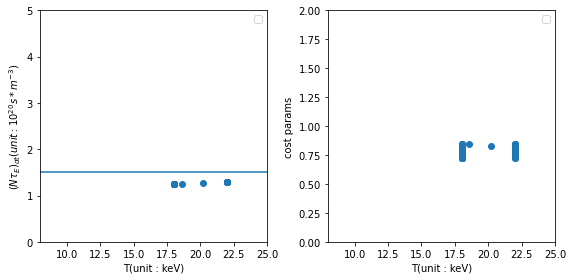

In [38]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [39]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 4.959
a : 1.771
blanket_thickness : 1.259
coil_thickness : 0.530
n : 1.070
TBR : 1.002
beta : 5.338
tau : 1.173
Ip : 17.676
q : 4.107
f_BS : 0.129
Q_parallel : 587.630
n_g : 1.794
q_kink : 2.000
beta_troyon : 5.920
f_NC : 0.589
n_tau : 1.255
n_tau_lower : 1.938
cost : 0.724
betan : 3.500
k : 1.700
epsilon : 2.800
electric_power : 1228935546.875
T_avg : 18.000
B0 : 16.000
H : 1.300
armour_thickness : 0.120
RF_recirculating_rate : 0.200
